In [29]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.datasets import mnist
import itertools
import random

In [30]:
# Load data and split into training and test
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [31]:
# Split training set further into training and validation sets
sample_size = 40000
X_train, X_val, y_train, y_val = train_images[:sample_size], train_images[sample_size:sample_size*2],  train_labels[:sample_size], train_labels[sample_size:sample_size*2]

Randomly sampling a subset of the data, to make the combinations more tractable. 

In [32]:
# Randomly select a defined number of image paires from a given dataset
def get_image_combinations(number_image_pairs_selected, image_data, image_labels):
    
    num_images_total = len(image_labels)
    
    image_combination_data = []
    image_combination_labels = []
    
    for i in range(number_image_pairs_selected):
        
        # Draw two image indices from a uniform random distribution
        random_index_A = random.randint(0, num_images_total-1)
        random_index_B = random.randint(0, num_images_total-1)
        
        # Randomly choose two images from the dataset
        image_A = image_data[random_index_A]
        image_B = image_data[random_index_B]
        
        # Merge images
        combined_images = np.hstack((image_A, image_B))
        
        # Find the minimum between the two labels
        label_A = image_labels[random_index_A]
        label_B = image_labels[random_index_B]
        minimum_label = min(label_A, label_B)
        
        # Append newly generated image combination and minimum label to list
        image_combination_data.append(combined_images)
        image_combination_labels.append(minimum_label)
        
    # Convert image data and labels lists to numpy arrays
    image_combination_data = np.array(image_combination_data)
    image_combination_labels = np.array(image_combination_labels)
    
    return image_combination_data, image_combination_labels

In [33]:
combo_train_X, combo_train_y = get_image_combinations(40000, X_train, y_train)
combo_val_X, combo_val_y = get_image_combinations(20000, X_val, y_val)

In [34]:
# Reshape the data so they can be fed into the network, one-hot-encode the labels

train_images = combo_train_X.reshape((combo_train_X.shape[0], 28, 56, 1))
train_images = train_images/ 255

val_images = combo_val_X.reshape((combo_val_X.shape[0], 28, 56, 1))
val_images = val_images/255

train_labels = to_categorical(combo_train_y)
val_labels = to_categorical(combo_val_y)

In [35]:
# Model architecture
def build_CNN():

    # Convolutional NN
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (28,56,1)))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    # Adding a NN Classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(10, activation = 'softmax'))

    model.compile(optimizer='rmsprop', 
                loss='categorical_crossentropy', 
                metrics=['accuracy', 'mae'])

    return model

In [36]:
model = build_CNN()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 26, 54, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 27, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 11, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 12, 64)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 3, 10, 64)         36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

In [13]:
# Fit model
model.fit(train_images, 
          train_labels, 
          epochs = 8, 
          batch_size = 64)

Epoch 1/8
625/625 [==============================] - 29s 45ms/step - loss: 0.4599 - accuracy: 0.8482 - mae: 0.0441
Epoch 2/8
625/625 [==============================] - 52s 83ms/step - loss: 0.1382 - accuracy: 0.9574 - mae: 0.0136
Epoch 3/8
625/625 [==============================] - 36s 58ms/step - loss: 0.0793 - accuracy: 0.9759 - mae: 0.0078
Epoch 4/8
625/625 [==============================] - 35s 55ms/step - loss: 0.0516 - accuracy: 0.9837 - mae: 0.0051
Epoch 5/8
625/625 [==============================] - 37s 59ms/step - loss: 0.0347 - accuracy: 0.9887 - mae: 0.0034
Epoch 6/8
625/625 [==============================] - 37s 60ms/step - loss: 0.0236 - accuracy: 0.9920 - mae: 0.0024
Epoch 7/8
625/625 [==============================] - 37s 59ms/step - loss: 0.0178 - accuracy: 0.9935 - mae: 0.0018
Epoch 8/8
625/625 [==============================] - 37s 59ms/step - loss: 0.0140 - accuracy: 0.9956 - mae: 0.0013


In [26]:
# Evaluate model on validation data
eval_model = model.evaluate(val_images, val_labels)
eval_model

625/625 [==============================] - 3s 4ms/step - loss: 0.1542 - accuracy: 0.9551 - mae: 0.0121


[0.15421541035175323, 0.9550999999046326, 0.01205873116850853]

In [ ]:
# Perform k-fold cross-validation to understand the optimal number of epochs to train on
k = 2
num_val_samples = len(train_images)//k

num_epochs = 20

all_val_mae_histories = []
all_train_mae_histories = []

for i in range(k):
    
    print('processing fold #', i)
    val_data = train_images[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_images[:i * num_val_samples],
    train_images[(i+1) * num_val_samples:]],
    axis = 0)
    
    partial_train_targets = np.concatenate(
    [train_labels[:i*num_val_samples],
    train_labels[(i+1)*num_val_samples:]],
    axis = 0)
    
    model = build_CNN()
    history = model.fit(partial_train_data,
              partial_train_targets,
              validation_data = (val_data, val_targets),
              epochs = num_epochs,
              batch_size = 64,
              verbose = 0)
    
    print(history.history.keys())
    
    val_mae_history = history.history['val_mae']
    all_val_mae_histories.append(val_mae_history)
    
    train_mae_history = history.history['mae']
    all_train_mae_histories.append(train_mae_history)

processing fold # 0
dict_keys(['loss', 'accuracy', 'mae', 'val_loss', 'val_accuracy', 'val_mae'])
processing fold # 1


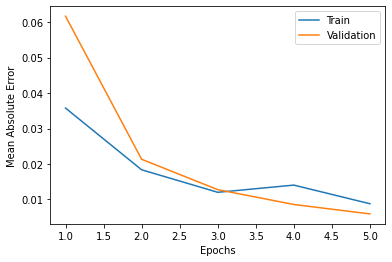

In [57]:
# Compute the average of the per-epoch MAE scores for all folds
# Building the history of successive mean K-fold validation scores

average_val_mae_history = [
    np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)]

average_train_mae_history = [
    np.mean([x[i] for x in all_train_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_val_mae_history) + 1), average_val_mae_history, label='Train')
plt.plot(range(1, len(average_train_mae_history) + 1), average_train_mae_history, label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [42]:
def smooth_curve(points, factor=0.5):
    
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 -factor))
        else:
            smoothed_points.append(point)
            
    return smoothed_points

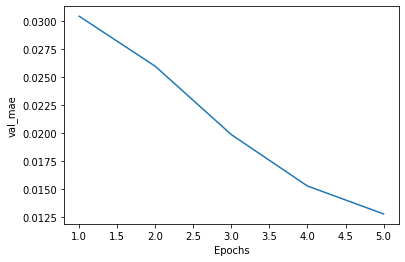

In [44]:
smooth_mae_history = smooth_curve(average_mae_history)
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('val_mae')
plt.show()

In [45]:
# serialize model to JSON
model_json = model.to_json()
with open("Q1_Trained_Models/CNN_Model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Q1_Trained_Models/CNN_Model.h5")
print("Saved model to disk")

Saved model to disk


In [46]:
# Verify above by visually inspecting images from the predicted set
num_val_images = 10000

Predicted: 2
True: 2


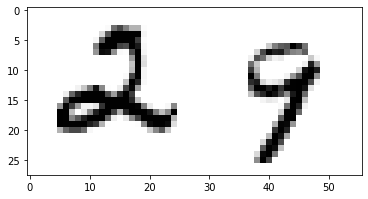

In [52]:
# Run this cell repeatedly to see multiple examples
check_index = random.randint(0,num_val_images)
plt.imshow(val_images[check_index].reshape(28,56), cmap = plt.cm.binary)
print("Predicted: " + str(np.argmax(y_predict[check_index])))
print("True: " + str(np.argmax(val_labels[check_index])))